In [120]:
import numpy as np
import pandas as pd
import seaborn as sns
from geopy.distance import vincenty
from math import sqrt
import xgboost as xgb
from sklearn.model_selection import KFold
from math import log
from math import atan2
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
import itertools
from datetime import datetime
import gc
from sklearn.model_selection import KFold

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)


In [3]:
def RMSLE(y_true, y_pred):
    return sqrt(np.mean((np.log(y_test + 1) - np.log(y_pred + 1))**2))

In [98]:
def weekday(col):
    
    weekday_ = np.zeros(col.shape[0], dtype='int')
    
    for j, day in enumerate(col):
        
        y, m, d = map(int, day.split(' ')[0].split('-'))
        DT = datetime(y, m, d)
        weekday_[j] = int(DT.isoweekday())
        
    return weekday_


def hour_cont(col):
    
    hour_ = np.zeros(col.shape[0])
    
    for j, time in enumerate(col):

        h, m, s = map(int, time.split(' ')[1].split(':'))
        hour_[j] = h + 0.01666*m + 0.00028*s
    
    return hour_


def hour(col):
    
    hour_ = np.zeros(col.shape[0], dtype='int')
    
    for j, time in enumerate(col):

        hour_[j] = time.split(' ')[1].split(':')[0]
    
    return hour_


def day_num(col):
    
    DM = [0, 31, 60, 91, 121, 152, 181]
    day_num_ = np.zeros(col.shape[0], dtype='int')
    
    for j, day in enumerate(col):
        
        y, m, d = map(int, day.split(' ')[0].split('-'))

        day_num_[j] = DM[m-1] + d

    return day_num_


def month(col):
    
    month_ = np.zeros(col.shape[0], dtype='int')
    
    for j, day in enumerate(col):

        y, m, d = map(int, day.split(' ')[0].split('-'))
        month_[j] = m
        
    return month_
    
    
def trip_dist(data):
    
    dist_ = np.zeros(data.shape[0])
    
    P_lat = data['pickup_latitude'].values
    P_long = data['pickup_longitude'].values
    
    D_lat = data['dropoff_latitude'].values
    D_long = data['dropoff_longitude'].values
    
    for j in xrange(data.shape[0]):
        

        Lat = (D_lat[j] - P_lat[j])*111.0
        Long = (D_long[j] - P_long[j])*85.4
        
    
        dist_[j] = sqrt(Lat*Lat + Long*Long)

            
    return dist_


def trip_direction(data):
    
    dir_ = np.zeros(data.shape[0])
    
    P_lat = data['pickup_latitude'].values
    P_long = data['pickup_longitude'].values
    
    D_lat = data['dropoff_latitude'].values
    D_long = data['dropoff_longitude'].values
    
    for j in xrange(data.shape[0]):
        

        Lat = (D_lat[j] - P_lat[j])*111.0
        Long = (D_long[j] - P_long[j])*85.4
        
    
        dir_[j] = atan2(Long,Lat)*57.3
            
    return dir_

## Prepare

In [5]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [129]:
skf = list(KFold(  shuffle=True, n_splits=10, random_state=115).split(train.trip_duration.values))

In [6]:
train = train[train.trip_duration < 7000]
train.drop('dropoff_datetime', axis=1)
train['week_day'] = weekday(train.pickup_datetime)
train['day_num'] = day_num(train.pickup_datetime)
train['hour_cont'] = hour_cont(train.pickup_datetime)
train['hour'] = hour(train.pickup_datetime)
train['month'] = month(train.pickup_datetime)
train['trip_dist'] = trip_dist(train)
train['trip_dir'] = trip_direction(train)
train['vel'] = train.trip_dist / train.trip_duration * 3600
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,week_day,day_num,hour_cont,hour,month,trip_dist,trip_dir,vel
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1,74,17.41524,17,3.0,1.518881,99.830786,12.017516
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,7,164,0.72618,0,6.0,1.824279,-116.815668,9.905588
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2,19,11.58982,11,1.0,6.385800,-159.414090,10.823390
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,3,97,19.54180,19,4.0,1.483253,-172.643245,12.446877
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6,86,13.51520,13,3.0,1.186506,179.478340,9.819364


In [105]:
def stacking(X_train, X_test, y_train, skf, clfs):
    meta_train = np.zeros((X_train.shape[0], len(clfs)))
    meta_test  = np.zeros((X_test.shape[0],  len(clfs)))
    
    for j, clf in enumerate(clfs):
        print('Clf', j+1)
        meta_test_j = np.zeros((X_test.shape[0], len(skf)))
        for i, (train, test) in enumerate(skf):
            print('Fold', i+1)
            X_tr = X_train[train]
            y_tr = y_train[train]
            X_ts = X_train[test]
            y_ts = y_train[test]
            clf.fit(X_tr, y_tr)
            y_submission = clf.predict_proba(X_ts)[:, 1]
            meta_train[test, j] = y_submission
            meta_test_j[:, i] = clf.predict_proba(X_test)[:, 1]
        meta_test[:, j] = meta_test_j.mean(1)
        gc.collect()
        
    return meta_train, meta_test

In [95]:
class PredictAverage:
    
    def __init__(self):
        self.Mean = {}
    
    def fit(self, data, col_names, target_name):
        
        self.col_names = col_names
        target = data[target_name].values
        
        cols = data[col_names].values
        
        #уникальные сочетания
        categories = np.unique(train[self.col_names].values, axis=0)

        for feature in categories:
            
            mask = True
            
            for i in xrange(len(col_names)):              
                mask = mask & (cols[:,i] == feature[i])
                
            self.Mean[tuple(feature)] = target[mask].mean()


        pass
    
        self.Mean[np.nan] = target.mean()
        
    def transform(self, data):
        
        Meta = np.zeros(data.shape[0])
        cols = data[self.col_names].values
        
        for j in xrange(cols.shape[0]):
            
            if tuple(cols[j]) in self.Mean:
                Meta[j] = self.Mean[tuple(cols[j])]
                
            else:
                Meta[j] = self.Mean[np.nan]
              
        return Meta
    
    def fit_transform(self, data, col_names, target_name):
        
        self.fit(data, col_names, target_name)
        return self.transform(data)
    

In [104]:
PA = PredictAverage()
PA.fit_transform(train, ['week_day', 'hour', 'month'], 'trip_duration')

array([ 809.59641533,  820.47979003,  961.40055827, ...,  695.74403056,
        950.13408939,  966.18192993])

In [103]:
train

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,week_day,day_num,hour_cont,hour,month,trip_dist,trip_dir,vel
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1,74,17.41524,17,3.0,1.518881,99.830786,12.017516
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,7,164,0.72618,0,6.0,1.824279,-116.815668,9.905588
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2,19,11.58982,11,1.0,6.385800,-159.414090,10.823390
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,3,97,19.54180,19,4.0,1.483253,-172.643245,12.446877
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6,86,13.51520,13,3.0,1.186506,179.478340,9.819364
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443,6,30,22.02786,22,1.0,1.105559,-45.443029,8.984227
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341,5,169,22.58296,22,6.0,1.335342,47.959120,14.097452
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551,6,142,7.91588,7,5.0,5.748628,135.955561,13.343045
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255,5,148,23.20636,23,5.0,1.323664,117.934234,18.687026
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225,4,70,21.74998,21,3.0,5.113614,7.725805,15.027764


In [42]:
col_names = ['week_day', 'hour']
cols = train[col_names].values

#уникальные сочетания
categories = np.unique(train[['week_day', 'hour']].values, axis=0)



In [61]:
a = cols[:,1] == categories[0,1]
b = cols[:,0] == categories[0,0]

In [68]:
a 

array([False,  True, False, ..., False, False, False], dtype=bool)

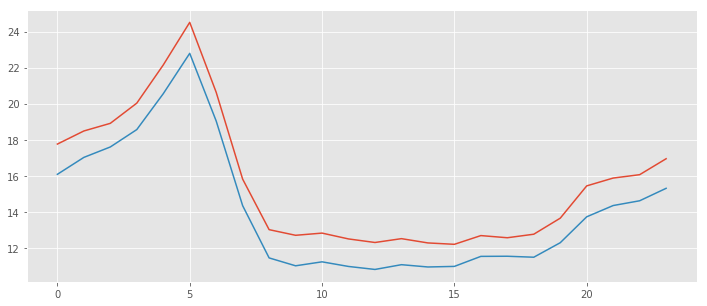

In [12]:
vel_av = np.zeros(24)
vel_m = np.zeros(24)

for i in xrange(24):
    vel_av[i] = train[train.hour == i].vel.mean() 
    vel_m[i] = train[train.hour == i].vel.median()
    
plt.plot(vel_av)
plt.plot(vel_m)
plt.show()

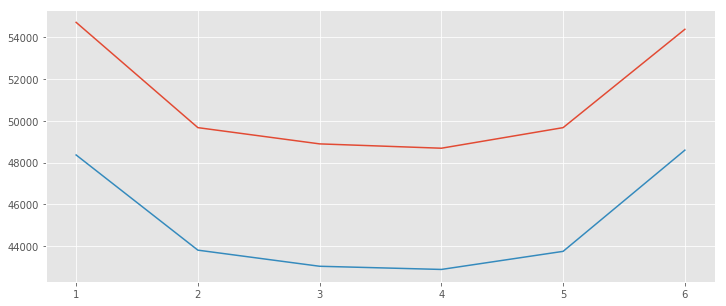

In [13]:
vel_av = np.zeros(7)
vel_m = np.zeros(7)

for i in xrange(7):
    vel_av[i] = train[train.week_day == i].vel.mean()*3600 
    vel_m[i] = train[train.week_day == i].vel.median()*3600 
    
plt.plot(vel_av)
plt.plot(vel_m)
plt.show()

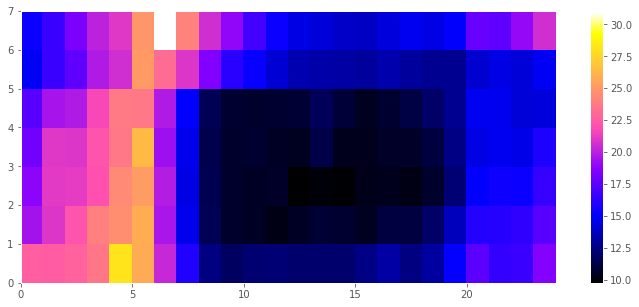

In [14]:
V = np.zeros((7, 24))
for d in xrange(1,8):
    for h in xrange(24):
        V[d-1,h] = `
        
plt.pcolor(V, cmap='gnuplot2')
plt.colorbar()
plt.grid(None)

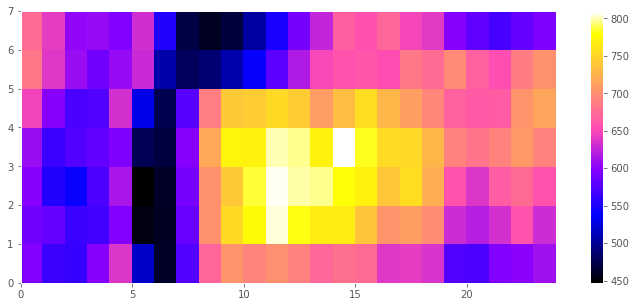

In [15]:
D = np.zeros((7, 24))
for d in xrange(1,8):
    for h in xrange(24):
        D[d-1,h] = train[(train.week_day == d) & (train.hour == h)].trip_duration.median()
        
plt.pcolor(D, cmap='gnuplot2')
plt.colorbar()
plt.grid(None)

In [19]:
X = train[['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 
           'dropoff_longitude', 'dropoff_latitude', 'week_day', 'day_num', 'hour_cont', 'trip_dist' ]].values
y = train.trip_duration.values

## fit

In [15]:
clf_xgb = xgb.XGBRegressor(n_estimators=100, n_jobs=8, max_depth=10, learning_rate=0.1)

clf_et = ExtraTreesClassifier(n_estimators=100, criterion='entropy', max_depth=37, max_features=25, 
                             min_samples_split=4, min_samples_leaf=2, n_jobs=-1, random_state=888)                

In [131]:
clf_rf =  RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=5, n_jobs=8)

In [16]:

kf = KFold(n_splits=3)

for train_ind, test_ind in kf.split(X,):
    
    X_train = X[train_ind]
    y_train = y[train_ind]
    
    X_test = X[test_ind]
    y_test = y[test_ind]

    clf_xgb.fit(X_train, y_train)
    
    y_pred = clf_xgb.predict(X_test)
    y_pred = np.array(map(lambda x: x if x>0 else 60.0 ,y_pred))
    
    print 'score', RMSLE(y_test, y_pred)

score 0.38990437884
score 0.38785661333
score 0.389890974726


In [82]:
y_pred = np.array(map(lambda x: x if x>0 else 60.0 ,y_pred))

In [133]:
sqrt(np.mean((np.log(y_test + 1) - np.log(y_pred + 1))**2))

0.3972782913654738

## Submission

In [92]:
test['week_day'] = weekday(test.pickup_datetime)
test['day_num'] = day_num(test.pickup_datetime)
test['hour_cont'] = hour_cont(test.pickup_datetime)
test['hour'] = hour(test.pickup_datetime)
test['trip_dist'] = trip_dist(test)
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,week_day,day_num,hour_cont,hour,trip_dist
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,4,182,23.99918,23,2.741780
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,4,182,23.99778,23,2.755119
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,4,182,23.99610,23,1.314481
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,4,182,23.99442,23,5.279292
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,4,182,23.99218,23,0.967963


In [119]:
X_subm = test[['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 
           'dropoff_longitude', 'dropoff_latitude', 'week_day', 'day_num', 'hour_cont', 'trip_dist' ]].values

In [134]:
y_subm = clf_rf.predict(X_subm)
y_subm = np.array(map(lambda x: x if x>0 else 60.0 , y_subm))


In [135]:
pd.read_csv('data/sample_submission.csv').head()

,id,trip_duration
0,id3004672,959
1,id3505355,959
2,id1217141,959
3,id2150126,959
4,id1598245,959


In [136]:
Subm = pd.DataFrame(columns=['id', 'trip_duration'])

In [137]:
Subm.id = test.id
Subm.trip_duration = y_subm

In [138]:
Subm.to_csv('data/subm.csv', index=False)